In [1]:
import numpy as np
import pandas as pd
import segyio
import matplotlib.pyplot as plt
import os
from scipy import signal as sc_signal
import random
from ukpgks import wiggle
import fcmeans as fcm

In [2]:
# load data
def read_segy(filename,flatten=True):
    """
    read traces to define shot time
    """
    with segyio.open(filename,'r',ignore_geometry=True) as segyfile:

        segyfile.mmap()
        data   = segyfile.trace.raw[:]
        index = np.arange(1,data.shape[0]+1,1)

        
        year   = segyfile.attributes(segyio.TraceField.YearDataRecorded)[:]
        day    = segyfile.attributes(segyio.TraceField.DayOfYear)[:]
        hour   = segyfile.attributes(segyio.TraceField.HourOfDay)[:]
        minute = segyfile.attributes(segyio.TraceField.MinuteOfHour)[:]
        second = segyfile.attributes(segyio.TraceField.SecondOfMinute)[:]
        
        hdr = [year,day,hour,minute,second]
        
        hdr = pd.DataFrame(data=np.array(hdr).T,index=index,
                           columns=['YEAR','DAY','HOUR','MINUTE','SECOND'])
    if flatten == True:
            data_fl   = data.flatten(order='C') 
    return data,data_fl,hdr
file = '1.segy'
data,data_fl,hdr = read_segy(file)
data_as_one_feature = data_fl.reshape(-1,1)

In [3]:
# load labels
time_labels = pd.read_csv('Shot_Stime_labels.csv')
print (data.shape,hdr.shape,time_labels.shape)

(1710, 5000) (1710, 5) (1710, 4)


   YEAR  DAY  HOUR  MINUTE  SECOND
1  2021  182    13      17      42
2  2021  182    13      17      45
3  2021  182    13      17      48
   TRACE HEADERTIME  TIME_shot_1  TIME_shot_2
0      1   13:17:42        915.6         3071
1      2   13:17:45        879.9         3725
2      3   13:17:48        729.3         4042


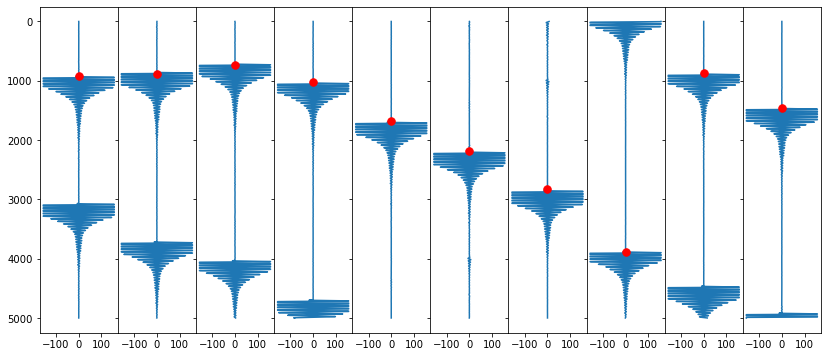

In [4]:
# select a few traces to test
traces_20 = np.copy(data[:21,:])
traces_20 = traces_20.T
print(hdr.head(3))
print (time_labels.head(3))

def PlotTraces(data,traces,figsize=(14,6)):
    fig,axs = plt.subplots(nrows=1,ncols=traces,figsize=figsize,sharey=True,
                           gridspec_kw = {'wspace':0, 'hspace':0})
    times = np.arange(0,data.shape[0],1)
    for i in range(traces):
        axs[i].plot(data[:,i],times)
        axs[i].plot(0,time_labels.iloc[i,2],'r.',markersize=15)

    plt.gca().invert_yaxis()
    
PlotTraces(traces_20,10)

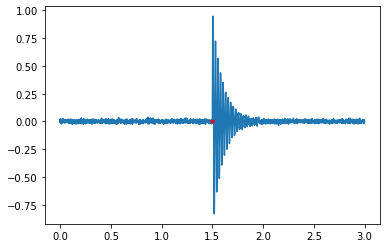

In [11]:
# make simple synthetic
dt = 0.001
tmax = .8
t = np.arange(0,tmax+dt,dt)
yt = np.sin(80*np.pi*t)*np.exp(-10*t) # signal
ns = yt.shape[0]
mu, sigma = 0, 0.01                           # mean and standard deviation
s = np.random.normal(mu, sigma, 3001)         # noise array
t = np.arange(0,s.shape[0]*dt,dt)
ts = int(1.5/dt)
s[ts:ts+ns] = s[ts:ts+ns] + yt                # add signal and noise
plt.plot(t,s)
plt.plot(1.5,0,'r.')

In [12]:
# make synthetic model
ns = 50        # number of traces
t1,t2 = 0.4,2  # labels range
nt = 3001      # time axis
train_data   = np.zeros([ns,nt])
train_labels = np.zeros(ns)
x = np.arange(0,50)
np.random.seed(42)
def create_model(train_data,t1,t2):
    
    dt = 0.001
    tmax = .8
    t = np.arange(0,tmax+dt,dt)
    y = np.sin(80*np.pi*t)*np.exp(-10*t) # signal
    ny = y.shape[0]
    
    for i in range(train_data.shape[0]):
        mu, sigma = 0, np.random.uniform(0.001, 0.015) # mean and standard deviation
        s = np.random.normal(mu, sigma, 3001)
        ts = np.round(np.random.uniform(0.4, 2.0),1)
        idx = int(ts/dt)
        s[idx:idx+ny] = s[idx:idx+ny] + y                # add signal and noise
        train_data[i,:] = s
        train_labels[i] = ts
    return train_data,train_labels

train_data,train_labels = create_model(train_data,t1,t2)

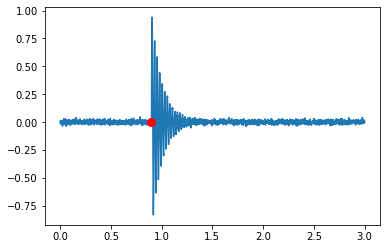

In [13]:
n = np.random.randint(low=0,high=49)
plt.plot(t,train_data[n,:])
plt.plot(train_labels[n],0,'ro',ms=8)

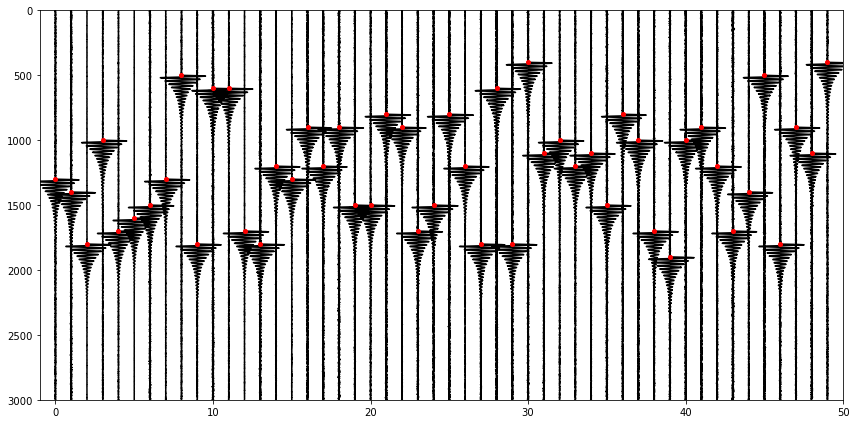

In [14]:
plt.figure(figsize=(12,6))
wiggle.wiggle(train_data.T)
plt.plot(x,train_labels/0.001,'r.',ms=8)
plt.tight_layout()

In [38]:
def delayed_sta_lta(a, nsta, nlta):
    """
    Delayed STA/LTA.

    :type a: NumPy :class:`~numpy.ndarray`
    :param a: Seismic Trace
    :type nsta: int
    :param nsta: Length of short time average window in samples
    :type nlta: int
    :param nlta: Length of long time average window in samples
    :rtype: NumPy :class:`~numpy.ndarray`
    :return: Characteristic function of delayed STA/LTA

    .. seealso:: [Withers1998]_ (p. 98) and [Trnkoczy2012]_
    """
    m = len(a)
    #
    # compute the short time average (STA) and long time average (LTA)
    # don't start for STA at nsta because it's muted later anyway
    sta = np.zeros(m, dtype=np.float64)
    lta = np.zeros(m, dtype=np.float64)
    for i in range(m):
        sta[i] = (a[i] ** 2 + a[i - nsta] ** 2) / nsta + sta[i - 1]
        lta[i] = (a[i - nsta - 1] ** 2 + a[i - nsta - nlta - 1] ** 2) / \
            nlta + lta[i - 1]
    sta[0:nlta + nsta + 50] = 0
    lta[0:nlta + nsta + 50] = 1  # avoid division by zero
    return sta,lta

In [15]:
def classic_sta_lta_py(a, nsta, nlta):
    """
    Computes the standard STA/LTA from a given input array a. The length of
    the STA is given by nsta in samples, respectively is the length of the
    LTA given by nlta in samples. Written in Python.

    .. note::

        There exists a faster version of this trigger wrapped in C
        called :func:`~obspy.signal.trigger.classic_sta_lta` in this module!

    :type a: NumPy :class:`~numpy.ndarray`
    :param a: Seismic Trace
    :type nsta: int
    :param nsta: Length of short time average window in samples
    :type nlta: int
    :param nlta: Length of long time average window in samples
    :rtype: NumPy :class:`~numpy.ndarray`
    :return: Characteristic function of classic STA/LTA
    """
    # The cumulative sum can be exploited to calculate a moving average (the
    # cumsum function is quite efficient)
    sta = np.cumsum(a ** 2, dtype=np.float64)

    # Copy for LTA
    lta = sta.copy()

    # Compute the STA and the LTA
    sta[nsta:] = sta[nsta:] - sta[:-nsta]
    sta /= nsta
    lta[nlta:] = lta[nlta:] - lta[:-nlta]
    lta /= nlta

    # Pad zeros
    sta[:nlta - 1] = 0

    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny

    return sta / lta
def mean(a,w):
    m = np.cumsum(a**2)
    m[w:] = m[w:] - m[:-w]
    m /= w
    return m

def power(a,w):
    m = np.cumsum(a**2)
    m[w:] = m[w:] - m[:-w]
    return m

(3001, 3)

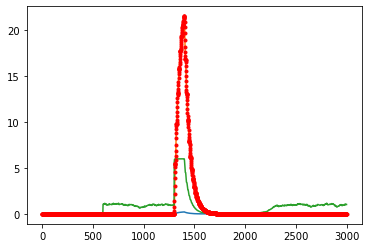

In [28]:
a = train_data[0,:]
a_m = mean(a,100)
a_p = power(a,100)
a_sl = classic_sta_lta_py(a,100,600)
X = np.array([a_m,a_p,a_sl])
X = X.T
plt.plot(a_m)
plt.plot(a_p)
plt.plot(a_sl)

plt.plot(X[:,1],'r.')
X.shape

In [29]:
model = fcm.FCM(n_clusters=2)
model.fit(X)

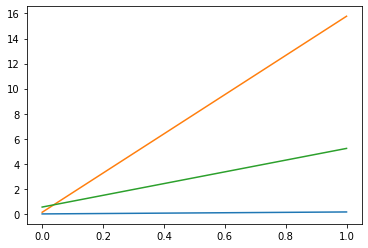

In [32]:
plt.plot(model.centers)

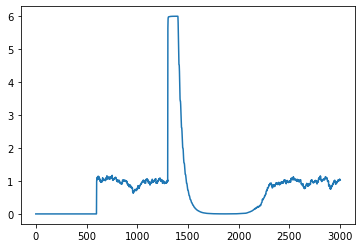

In [51]:
plt.plot(s)

In [35]:
s= model.predict(X)

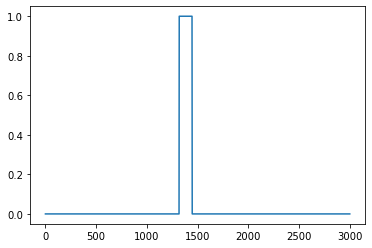

In [36]:
plt.plot(s)